# Supervised Learning (Decision Tree)

We moeten een decision tree maken en trainen om te voorspellen wat de eventuele return-reden is van een bestellingsproduct.

In [45]:
# Imports
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [46]:
# Load Dataset
sales_conn = sqlite3.connect("../data/go_sales_volledig.sqlite")

# We importeren de daadwerkelijke return-reden niet, omdat we alleen de ID nodig hebben tijdens het trainen.
orders = pd.read_sql_query(
    "SELECT * "
    "FROM order_details od "
    "JOIN order_header oh ON od.ORDER_NUMBER = oh.ORDER_NUMBER "
    "LEFT JOIN returned_item ri ON od.ORDER_DETAIL_CODE = ri.ORDER_DETAIL_CODE",
    sales_conn,
)
orders.dtypes

ORDER_DETAIL_CODE          int64
ORDER_NUMBER               int64
PRODUCT_NUMBER             int64
QUANTITY                   int64
UNIT_COST                float64
UNIT_PRICE               float64
UNIT_SALE_PRICE          float64
ORDER_NUMBER               int64
RETAILER_NAME             object
RETAILER_SITE_CODE         int64
RETAILER_CONTACT_CODE      int64
SALES_STAFF_CODE           int64
SALES_BRANCH_CODE          int64
ORDER_DATE                object
ORDER_METHOD_CODE          int64
RETURN_CODE              float64
RETURN_DATE               object
ORDER_DETAIL_CODE        float64
RETURN_REASON_CODE       float64
RETURN_QUANTITY          float64
dtype: object

In [47]:
# Data Preprocessing

orders = orders.loc[:, ~orders.columns.duplicated()]

orders["RETURN_REASON_CODE"] = orders["RETURN_REASON_CODE"].fillna(-1).astype(int)

orders["ORDER_DATE"] = pd.to_datetime(orders["ORDER_DATE"])
orders["ORDER_YEAR"] = orders["ORDER_DATE"].dt.year
orders["ORDER_MONTH"] = orders["ORDER_DATE"].dt.month

orders = orders.drop(columns=["ORDER_DATE", "RETAILER_NAME", "RETURN_DATE"])

orders.dtypes

ORDER_DETAIL_CODE          int64
ORDER_NUMBER               int64
PRODUCT_NUMBER             int64
QUANTITY                   int64
UNIT_COST                float64
UNIT_PRICE               float64
UNIT_SALE_PRICE          float64
RETAILER_SITE_CODE         int64
RETAILER_CONTACT_CODE      int64
SALES_STAFF_CODE           int64
SALES_BRANCH_CODE          int64
ORDER_METHOD_CODE          int64
RETURN_CODE              float64
RETURN_REASON_CODE         int64
RETURN_QUANTITY          float64
ORDER_YEAR                 int32
ORDER_MONTH                int32
dtype: object

In [48]:
# Dummy Encoding
orders_encoded = pd.get_dummies(
    orders,
    columns=[
        "PRODUCT_NUMBER",
        "SALES_BRANCH_CODE",
        "SALES_STAFF_CODE",
        "ORDER_METHOD_CODE",
        "RETAILER_SITE_CODE",
        "RETAILER_CONTACT_CODE",
    ],
    drop_first=True,
)

orders_encoded.dtypes

ORDER_DETAIL_CODE              int64
ORDER_NUMBER                   int64
QUANTITY                       int64
UNIT_COST                    float64
UNIT_PRICE                   float64
                              ...   
RETAILER_CONTACT_CODE_458       bool
RETAILER_CONTACT_CODE_459       bool
RETAILER_CONTACT_CODE_460       bool
RETAILER_CONTACT_CODE_461       bool
RETAILER_CONTACT_CODE_462       bool
Length: 1014, dtype: object

In [49]:
# Split Data
X = orders_encoded.drop(columns=["RETURN_REASON_CODE"])
y = orders_encoded["RETURN_REASON_CODE"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [50]:
# Train Model
# tree = DecisionTreeClassifier(class_weight="balanced", random_state=42)
tree = RandomForestClassifier(class_weight="balanced", random_state=42)
tree.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


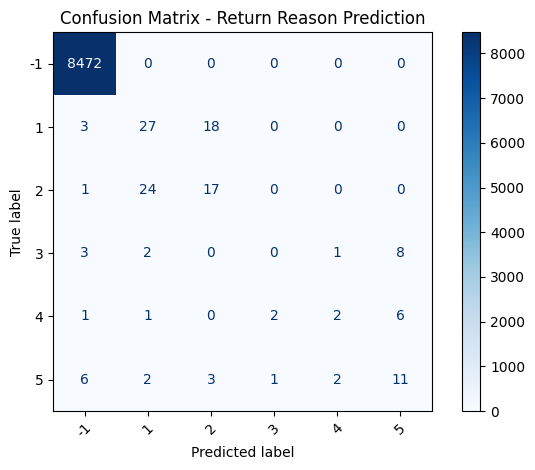

In [51]:
# Evaluate Model
y_pred = tree.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique()))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Return Reason Prediction")
plt.tight_layout()
plt.show()